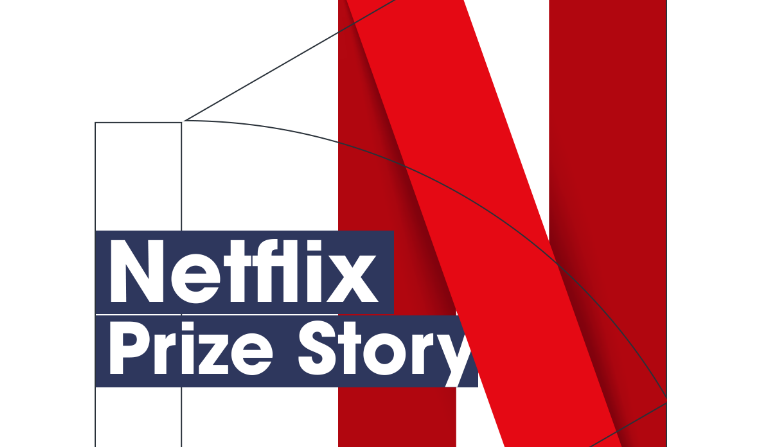

El Netflix Prize fue una competencia que comenzó en 2006 donde Netflix ofreció un premio de $1,000,000 a quien pudiera producir un algoritmo de recomendación que fuera al menos un 10% mejor que su propio algoritmo en ese momento. El concurso atrajo la atención mundial y tuvo un impacto significativo en el campo de los sistemas de recomendación y la ciencia de datos.

La base de datos del Netflix Prize consiste en:

 - Más de 100 millones de calificaciones (ratings) de películas. Estas calificaciones son valores enteros entre 1 y 5.

 - Las calificaciones pertenecen a 480,189 usuarios que han calificado entre 1 y 4,819 películas. En promedio, un usuario calificó 209 películas.

 - 17,770 películas están presentes en el conjunto de datos.

Cada registro del conjunto de datos consiste en:

 - ID del cliente: Un número entero que identifica de manera única a un cliente.
 - Calificación (rating): El número de estrellas asignado por el revisor a la película, que va desde 1 hasta 5.
 - ID de la película la cual valoró el cliente


El objetivo de este trabajo es abarcar un problema de

Librerías

In [1]:
%pip install surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
import sys
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
# Cargamos la data en bruto
data = pd.read_csv("/content/drive/MyDrive/Topicos/ratings_netflix.csv")

print("Dimensiones:", data.shape)


Dimensiones: (100480507, 3)


In [3]:
columnas = ["MovieID", "Year", "Title"]

archivo_txt = '/content/drive/MyDrive/Topicos/movie_titles.txt'
max_delimiter = 2
filas = []
with open(archivo_txt, 'r', encoding="ISO-8859-1") as file:
    for linea in file:
      partes = linea.strip().split(',', max_delimiter)
      fila = partes[:max_delimiter + 1]
      if len(fila[2].split(",")) > 1:
        fila[2] = fila[2].split(",")[1]
      filas.append([int(fila[0]), fila[1], fila[2]])

movie_titles = pd.DataFrame(filas, columns = columnas)

display(movie_titles.head())
print("Dimensiones:", movie_titles.shape)

,MovieID,Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


Dimensiones: (17770, 3)


In [4]:
# Miramos la cantidad de peliculas por año
movie_titles.groupby("Year")["MovieID"].count()

Year
1896       1
1909       1
1914       2
1915       5
1916       4
        ... 
2002    1310
2003    1271
2004    1436
2005     512
NULL       7
Name: MovieID, Length: 95, dtype: int64

In [5]:
# Agregamos las fechas que no poseen informacion (fuente: google)
movie_titles.loc[movie_titles["Year"] == "NULL", "Year"] = ["2001", "2002", "2002", "1974", "1999", "1994", "1999"]

# Convertimos Year a formato numero entero
movie_titles['Year'] = movie_titles['Year'].astype(int)

## Análisis exploratorio
Buscamos películas sin valoración, o más bien datos faltantes a fin de separarlos de la data original

In [6]:
print("Cantidad de usuarios únicos: ", data["CustomerID"].nunique())
print("Cantidad de películas: ", data["MovieID"].nunique())

Cantidad de usuarios únicos:  480189
Cantidad de películas:  17770


In [7]:
# Buscamos valores NA
datos_faltantes = data[data.isna().any(axis=1)]
datos_faltantes.shape

(0, 3)

In [8]:
# Buscamos usuarios que hayan calificado la misma pelicula más de una vez
duplicados = data[data[["CustomerID", "MovieID"]].duplicated(keep = False)]
duplicados.shape

(0, 3)

In [9]:
# Buscamos anomalías en los ratings
escala = [1,2,3,4,5]

ratings_malos = data[~data.Rating.isin(escala)] # Buscamos filas cuyo rating esté fuera de escala
ratings_malos.shape


(0, 3)

In [10]:
# Valores unicos de Rating
pd.unique(data["Rating"])

array([3, 5, 4, 2, 1])

### Valoraciones por película
Creamos un boxplot que muestre la cantidad de valoraciones que existe por pelicula, de modo que nos sirva para determinar un número mínimo de valoraciones por película.

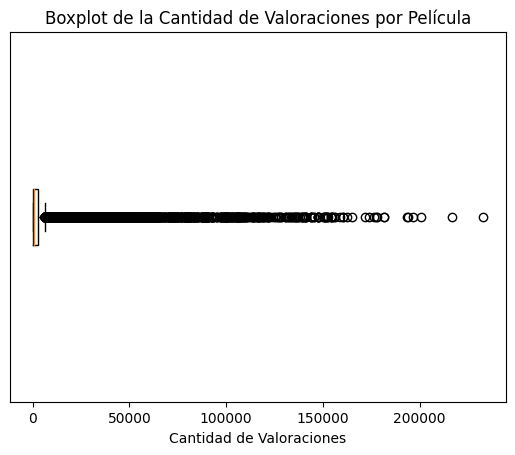

In [11]:
valoraciones_por_pelicula = data.groupby('MovieID')['Rating'].count()

# Convierte la serie resultante en un DataFrame para facilitar la manipulación.
df_valoraciones_por_pelicula = valoraciones_por_pelicula.reset_index()

# Crea un boxplot de la cantidad de valoraciones por película.
plt.boxplot(df_valoraciones_por_pelicula['Rating'], vert=False)
plt.title('Boxplot de la Cantidad de Valoraciones por Película')
plt.xlabel('Cantidad de Valoraciones')
plt.yticks([])
plt.show()

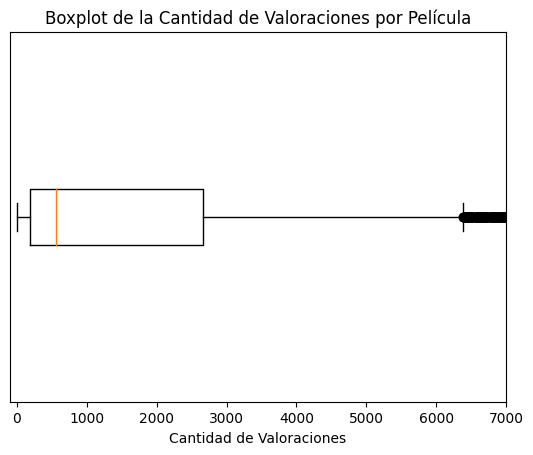

In [16]:
# Crea un boxplot de la cantidad de valoraciones por película.
#plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura si es necesario.
plt.boxplot(df_valoraciones_por_pelicula['Rating'], vert=False)
plt.title('Boxplot de la Cantidad de Valoraciones por Película')
plt.xlabel('Cantidad de Valoraciones')
plt.yticks([])
plt.xlim(left = -100, right = 7000)
plt.show()




In [13]:
aux_peliculas = df_valoraciones_por_pelicula.sort_values(by = ["Rating"])
min_valoraciones = 50
total_peliculas = aux_peliculas[aux_peliculas["Rating"] <= min_valoraciones].count()
tasa = round(total_peliculas.Rating/aux_peliculas['Rating'].count()*100, 2)

print(f"Un total de", total_peliculas.Rating, "películas posee a lo más", min_valoraciones, "valoraciones. Lo que equivale a un", tasa, "% del total de películas")


Un total de 59 películas posee a lo más 50 valoraciones. Lo que equivale a un 0.33 % del total de películas


### Valoraciones por usuario
Creamos un boxplot que muestre la cantidad de valoraciones que existe por pelicula, de modo que nos sirva para determinar un número mínimo de valoraciones por película.

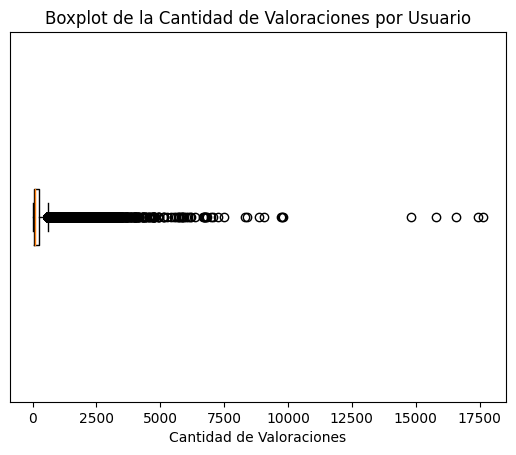

In [14]:
valoraciones_por_usuario = data.groupby('CustomerID')['Rating'].count()

# Convierte la serie resultante en un DataFrame para facilitar la manipulación.
df_valoraciones_por_usuario = valoraciones_por_usuario.reset_index()

# Crea un boxplot de la cantidad de valoraciones por película.
plt.boxplot(df_valoraciones_por_usuario['Rating'], vert=False)
plt.title('Boxplot de la Cantidad de Valoraciones por Usuario')
plt.xlabel('Cantidad de Valoraciones')
plt.yticks([])
plt.show()

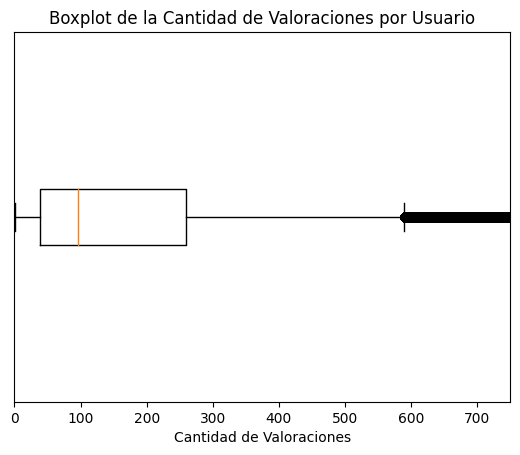

In [17]:
# Crea un boxplot de la cantidad de valoraciones por película.
plt.boxplot(df_valoraciones_por_usuario['Rating'], vert=False)
plt.title('Boxplot de la Cantidad de Valoraciones por Usuario')
plt.xlabel('Cantidad de Valoraciones')
plt.yticks([])  # Elimina las marcas del eje y si no son necesarias.
plt.xlim(left = 0, right = 750)
plt.show()

In [18]:
aux_usuarios = df_valoraciones_por_usuario.sort_values(by = ["Rating"])
min_valoraciones = 10
total_usuarios = aux_usuarios[aux_usuarios["Rating"] <= min_valoraciones].count()
tasa = round(total_usuarios.Rating/aux_usuarios['Rating'].count()*100, 2)

print(f"Un total de", total_usuarios.Rating, "usuarios posee a lo más", min_valoraciones, "valoraciones. Lo que equivale a un", tasa, "% del total de usuarios")

Un total de 18745 usuarios posee a lo más 10 valoraciones. Lo que equivale a un 3.9 % del total de usuarios


## Distribucion años por pelicula
La distribucion de las peliculas por año puede ser de utilidad para determinar en qué períodos es más probable tener menor cantidad de valoraciones dada la actualidad en la que vive cada persona y por ende sus intereses, los cuales se pueden ver afectados por una ola de nuevas tecnologías.

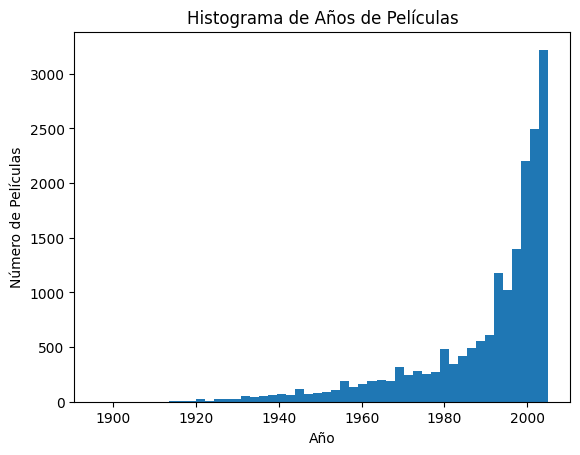

In [19]:

# Dibuja el histograma
#plt.figure(figsize=(12, 6))
movie_titles['Year'].hist(bins=50)  # Ajusta el número de bins según sea necesario
plt.title('Histograma de Años de Películas')
plt.xlabel('Año')
plt.ylabel('Número de Películas')
plt.grid(False)
plt.show()

### Filtro de datos con poca concurrencia
Descartamos las películas y usuarios con pocas valoraciones. Para esto filtramos por las películas con 30 o menos valoraciones y usuarios con 5 o menos valoraciones.

In [20]:
min_ratings = 50
filter_items = data["MovieID"].value_counts() > min_ratings
filter_items = filter_items[filter_items].index.tolist()

min_user_ratings = 10
filter_users = data['CustomerID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

data = data[(data['MovieID'].isin(filter_items)) & (data['CustomerID'].isin(filter_users))]

del filter_items
del filter_users

In [21]:
# Tasa de valoraciones por rating
cantidad_valoraciones = data.groupby("Rating")["Rating"].count()
tasa_valoraciones = cantidad_valoraciones / data["Rating"].count()

pd.DataFrame({"Cantidad valoraciones" : cantidad_valoraciones,
              "Tasa" : tasa_valoraciones})

,Cantidad valoraciones,Tasa
Rating,,
1,4610366,0.045933
2,10121419,0.100840
3,28787006,0.286806
4,33715785,0.335912
5,23136395,0.230509


Para los datos de calificación, el rendimiento del algoritmo de recomendación se puede mejorar eliminando el sesgo de calificación de los usuarios, donde algunos usuarios tienden a usar siempre calificaciones más altas mientras que otros tienden a usar calificaciones más bajas.

# Preparación de la data para Filtrado Colaborativo

## Algoritmo Map Reduce
El objetivo de implementar este algoritmo es principalmente el desafío que conlleva trabajar con una gran cantidad de datos como lo son 100 millones. Por ende, se empezará a trabajar en torno a algún usuario de interés (pero no enfocado en un 100%) y que luego se quiera predecir su valoración frente alguna película mediante la metodología de ***Filtrado Colaborativo basado en Modelos*** utilizando la descomposición de valores singulares. Sin embargo, el proceso de mapeo estará orientado a identificar películas similares basándose en un conjunto de usuarios que han valorado dichas películas, siendo esto parte de una técnica utilizada en un enfoque de ***Filtrado Colaborativo basado en Ítems***.


In [31]:
def shuffle_sort(user_movie_dict, movie_id, k):
  # Input :
  # user_movie_dict -> {user_id: [pelicula_1],...,[pelicula_n]}
  # movie_id : pelicula inputada en mapper

  # Objetivo : identificar usuarios en común que hayan valorado movie_id y la película actual

  list_users_movie_id = user_movie_dict[movie_id]
  movies = []
  for movie, user_list in user_movie_dict.items():
      if movie_id != movie:
        usuarios_comunes = set(list_users_movie_id).intersection(set(user_list))
        if len(usuarios_comunes) > k:
          movies.append(movie)
  return movies


def mapper(input, k):
  # Input : "user_id, movie_id"
  # k : mínimo de vecinos similares
  user_id, movie_id = map(int, input.split(','))

  # Restricciones ideales (es decir, no se supervisa):
  # 1. El usuario debe pertenecer a la base de datos
  # 2. La película (movie_id) no la debe haber calificado previamente

  # Peliculas que ha visto el usuario
  user_movies = data[data['CustomerID'] == user_id]["MovieID"].tolist()

  # Identifico a los usuarios que calificaron la pelicula Y comparten las mismas peliculas
  unique_users = data[(data["MovieID"] == movie_id) & (data["MovieID"].isin(user_movies))]["CustomerID"].unique().tolist()
  if len(unique_users) == 0:
    print("No hay usuarios que han calificado la pelicula y que a su vez hayan visto las mismas peliculas del usuario!")
    sys.exit()

  # Filtramos la data por aquellos usuarios identificados
  movies_unique_users = data[data["CustomerID"].isin(unique_users)]

  # Identificamos las peliculas que han visto aquellos usuarios
  def convert_to_list(group):
   return group["CustomerID"].values.tolist()

  # Guardamos la información en un diccionario
  user_movie_dict = movies_unique_users[["CustomerID", "MovieID"]].groupby('MovieID').apply(convert_to_list).to_dict()

  # Identificamos a los usuarios que hayan calificado las mismas peliculas
  pre_clusters = shuffle_sort(user_movie_dict, movie_id, k)

  return (pre_clusters, movies_unique_users, movie_id)


def reduce(map):
  peliculas_comunes = map[0]
  peliculas_comunes.append(map[2]) # se agrega la pelicula inputada al inicio
  data = map[1][map[1]["MovieID"].isin(peliculas_comunes)]
  return data



### Map


In [32]:
input_value = "2442 ,10231" # user_id, movie_id
mapeo = mapper(input_value, k = 10000)


Reduce

In [34]:
reducir = reduce(mapeo)

In [35]:
reducir.shape

(3017658, 3)

In [36]:
reader = Reader(rating_scale=(1,5))
data_surprise = Dataset.load_from_df(df=reducir[["CustomerID", "MovieID", "Rating"]],reader=reader)
trainset, testset = train_test_split(data_surprise, test_size=0.3, random_state = 3407)

## Ajuste del modelo

In [37]:
model = SVD()
model.fit(trainset)

Al no entregar argumentos a la función SVD() se asume que el número de factores latentes es 100, además como vimos existe una tendencia a tener valoraciones más altas que bajas por lo que se añaden términos de sesgo a la estimación (por defecto `biased = True`)

## Predicciones
Testeamos el modelo y observamos el error cuadrático medio

In [38]:
predictions = model.test(testset)

In [39]:
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

RMSE: 0.8058
RMSE: 0.8057686654965543


Ahora queremos predecir la valoración para el usuario que inputamos en un inicio

In [40]:
usuario_id = 2442
pelicula_id = 10231
prediccion = model.predict(usuario_id, pelicula_id)
print(f"La valoración estimada del usuario {usuario_id} para la película {pelicula_id} es {prediccion.est:.2f}")


La valoración estimada del usuario 2442 para la película 10231 es 2.63


In [41]:
valoracion_real = reducir.loc[(reducir['CustomerID'] == usuario_id) & (reducir['MovieID'] == pelicula_id), 'Rating'].values

if valoracion_real.size > 0:
    print(f"La valoración real del usuario {usuario_id} para la película {pelicula_id} es {valoracion_real[0]}")
else:
    print(f"No se encontró una valoración real del usuario {usuario_id} para la película {pelicula_id}")

La valoración real del usuario 2442 para la película 10231 es 2


También nos podría interesar predecir la valoración de algún usuario dentro del set de datos de validación

In [42]:
testset[:10]

[(661454, 483, 4.0),
 (342695, 15393, 3.0),
 (2289991, 15124, 3.0),
 (732775, 3917, 2.0),
 (405075, 5732, 5.0),
 (1029283, 5926, 5.0),
 (1130826, 16265, 5.0),
 (664750, 1307, 3.0),
 (1471913, 10550, 4.0),
 (666611, 14410, 2.0)]

In [43]:
usuario_id = 661454
pelicula_id = 483
prediccion = model.predict(usuario_id, pelicula_id)
print(f"La valoración estimada del usuario {usuario_id} para la película {pelicula_id} es {prediccion.est:.2f}")

La valoración estimada del usuario 661454 para la película 483 es 4.24
